In [1]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
conv_base = VGG19(weights = 'imagenet', 
                  include_top = False, input_shape = (224,224,3))

80142336/80134624 [==============================] - 30s 0us/step


In [3]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
conv_base.trainable = False
#print(len(model.trainable_weights))

In [5]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 26,447,939
Trainable params: 6,423,555
Non-trainable params: 20,024,384
_________________________________________________________________


In [7]:
train_dir = 'C:/Users/DELL/Documents/GitHub/covid-x-ray-classification/data/train'
test_dir = 'C:/Users/DELL/Documents/GitHub/covid-x-ray-classification/data/test'
dev_dir = 'C:/Users/DELL/Documents/GitHub/covid-x-ray-classification/data/validation'
train_datagen = ImageDataGenerator(rescale=1./255)#rescale=1./255
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=20,target_size=(224, 224),
                                                    class_mode='categorical', shuffle =True, seed = 42)
dev_datagen = ImageDataGenerator(rescale=1./255)#rescale=1./255
dev_generator = dev_datagen.flow_from_directory(dev_dir,target_size=(224, 224),
                                                class_mode='categorical', shuffle =True, seed = 42)
test_datagen = ImageDataGenerator(rescale=1./255)#rescale=1./255
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=20,target_size=(224, 224),
                                                  class_mode='categorical', shuffle = False, seed=42)

Found 2560 images belonging to 3 classes.
Found 176 images belonging to 3 classes.
Found 169 images belonging to 3 classes.


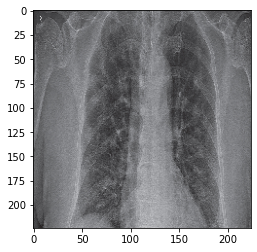

In [8]:
img = image.load_img(train_generator.filepaths[0], target_size=(224,224))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.imshow(image.array_to_img(x[0]))

In [9]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(),metrics=['acc'])

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=dev_generator.n//dev_generator.batch_size
############################################################################################
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=dev_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128 steps, validate for 5 steps
Epoch 1/20
128/128 [==============================] - 54s 419ms/step - loss: 0.8415 - acc: 0.8316 - val_loss: 0.1962 - val_acc: 0.9312
Epoch 2/20
128/128 [==============================] - 51s 399ms/step - loss: 0.2336 - acc: 0.9168 - val_loss: 0.2024 - val_acc: 0.9250
Epoch 3/20
128/128 [==============================] - 51s 399ms/step - loss: 0.2016 - acc: 0.9262 - val_loss: 0.1520 - val_acc: 0.9500
Epoch 4/20
128/128 [==============================] - 51s 401ms/step - loss: 0.1718 - acc: 0.9406 - val_loss: 0.1448 - val_acc: 0.9563
Epoch 5/20
128/128 [==============================] - 51s 402ms/step - loss: 0.1697 - acc: 0.9438 - val_loss: 0.1365 - val_acc: 0.9312
Epoch 6/20
128/128 [==============================] - 52s 403ms/step - loss: 0.1508 - acc: 0.9453 - val_loss: 0.1269 - val_acc: 0.9563
Epoch 7/20
128/128 [==

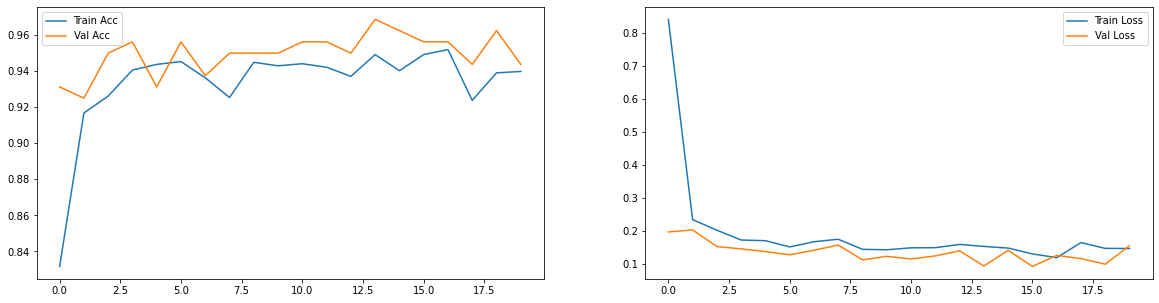

In [11]:
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label = 'Train Acc')
plt.plot(history.history['val_acc'], label = 'Val Acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.legend()

In [12]:
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict(test_generator)
preds = []
for i in range(len(predict)):
    preds.append(np.argmax(predict[i, :]))   

In [13]:
test_generator.class_indices

{'covid': 0, 'normal': 1, 'viral': 2}

In [14]:
confusion_matrix(test_generator.classes, preds)

array([[21,  1,  7],
       [ 2, 68,  0],
       [ 0,  1, 69]], dtype=int64)

In [15]:
print(classification_report(test_generator.classes, preds))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81        29
           1       0.97      0.97      0.97        70
           2       0.91      0.99      0.95        70

    accuracy                           0.93       169
   macro avg       0.93      0.89      0.91       169
weighted avg       0.94      0.93      0.93       169

